<a href="https://colab.research.google.com/github/raj-vijay/mv/blob/master/11_Lab_10_RANdom_SAampling_Consensus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BACKGROUND**

In this exercise you will refine the algorithm developed in Lab08 to be more robust towards outliers in the feature tracking using the RANdom SAmpling Consensus (RANSAC) algorithm. 

This approach will help identify outliers in the data and select the best point correspondences for the calculation of the image to image homographies used for stitching the image panorama.</p>

In [ ]:
import cv2
import numpy as np
import random

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
!wget https://github.com/raj-vijay/mv/raw/master/images/courtyard.mp4

--2021-05-01 21:20:43--  https://github.com/raj-vijay/mv/raw/master/images/courtyard.mp4
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/raj-vijay/mv/master/images/courtyard.mp4 [following]
--2021-05-01 21:20:43--  https://raw.githubusercontent.com/raj-vijay/mv/master/images/courtyard.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8180413 (7.8M) [application/octet-stream]
Saving to: ‘courtyard.mp4’

courtyard.mp4       100%[===================>]   7.80M  15.4MB/s    in 0.5s    

2021-05-01 21:20:44 (15.4 MB/s) - ‘courtyard.mp4’ saved [8180413/8180413]



In [ ]:
def get_tracks(filename):
    camera = cv2.VideoCapture(filename)

    # initialise features to track
    while camera.isOpened():
        ret,img= camera.read()        
        if ret:
            new_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)        
            p0 = cv2.goodFeaturesToTrack(new_img, 200, 0.3, 7)                                    
            break    

    # initialise tracks
    index = np.arange(len(p0))
    tracks = {}
    for i in range(len(p0)):
        tracks[index[i]] = {0:p0[i]}
                
    frame = 0
    while camera.isOpened():
        ret,img= camera.read()                 
        if not ret:
            break

        frame += 1

        old_img = new_img
        new_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)        

        # calculate optical flow
        if len(p0)>0: 
            p1, st, err  = cv2.calcOpticalFlowPyrLK(old_img, new_img, p0, None)                                    
            
            # visualise points
            for i in range(len(st)):
                if st[i]:
                    cv2.circle(img, (int(p1[i,0,0]),int(p1[i,0,1])), 2, (0,0,255), 2)
                    cv2.line(img, (int(p0[i,0,0]),int(p0[i,0,1])), (int(p0[i,0,0]+(p1[i][0,0]-p0[i,0,0])*5),int(p0[i,0,1]+(p1[i][0,1]-p0[i,0,1])*5)), (0,0,255), 2)            
            
            p0 = p1[st==1].reshape(-1,1,2)            
            index = index[st.flatten()==1]
                
            
        # refresh features, if too many lost
        if len(p0)<100:
            new_p0 = cv2.goodFeaturesToTrack(new_img, 200-len(p0), 0.3, 7)
            for i in range(len(new_p0)):
                if np.min(np.linalg.norm((p0 - new_p0[i]).reshape(len(p0),2),axis=1))>10:
                    p0 = np.append(p0,new_p0[i].reshape(-1,1,2),axis=0)
                    index = np.append(index,np.max(index)+1)

        # update tracks
        for i in range(len(p0)):
            if index[i] in tracks:
                tracks[index[i]][frame] = p0[i]
            else:
                tracks[index[i]] = {frame: p0[i]}

        # visualise last frames of active tracks
        for i in range(len(index)):
            for f in range(frame-20,frame):
                if (f in tracks[index[i]]) and (f+1 in tracks[index[i]]):
                    cv2.line(img,
                             (int(tracks[index[i]][f][0,0]),int(tracks[index[i]][f][0,1])),
                             (int(tracks[index[i]][f+1][0,0]),int(tracks[index[i]][f+1][0,1])), 
                             (0,255,0), 1)

      
    return tracks, frame

In [ ]:
def skew(x):
    return np.array([[0,-x[2],x[1]],
                     [x[2],0,-x[0]],
                     [-x[1],x[0],0]])

In [ ]:
def calculate_homography_RANSAC(tracks, frame1, frame2):
    correspondences = []
    for track in tracks:
        if (frame1 in tracks[track]) and (frame2 in tracks[track]):
            x1 = [tracks[track][frame1][0,1],tracks[track][frame1][0,0],1]
            x2 = [tracks[track][frame2][0,1],tracks[track][frame2][0,0],1]
            correspondences.append((np.array(x1), np.array(x2)))
    
    best_outliers = len(correspondences)+1
    best_error = 1e100
    best_H = np.eye(3)
    for iteration in range(1000):
        samples_in = set(random.sample(range(len(correspondences)),4))
        samples_out = set(range(len(correspondences))).difference(samples_in)
            
        A = np.zeros((0,9))
        factor = {}
        for i in samples_in:
            x1,x2 = correspondences[i]
            Ai = np.kron(x1.T,skew(x2))
            factor[i] = 1.0 / np.sqrt(np.sum(Ai.flatten()**2))
            Ai = Ai[[0,1],:]
            Ai = factor[i] * Ai 
            A = np.append(A,Ai,axis=0)
    
        U,S,V = np.linalg.svd(A)    
        H = V[8,:].reshape(3,3).T
                        
        count_outliers = 0
        accumulate_error = 0
        for i in samples_out:
            x1,x2 = correspondences[i]
            Bi1 = np.matmul(skew(x2),H)
            Bi1 = Bi1[[0,1],:]
            Bi2 = -skew(np.matmul(H,x1))
            Bi2 = Bi2[[0,1],:]
    
            Cgg = np.matmul(np.matmul(Bi1, np.diag([1,1,0])), Bi1.T)    
            Cgg += np.matmul(np.matmul(Bi2, np.diag([1,1,0])), Bi2.T)    
            
            Cgg_inv = np.linalg.inv(Cgg) 
            y = np.matmul(Bi1,x1)                
            T = np.matmul(np.matmul(y.T, Cgg_inv), y)
            
            if T>9.21:
                count_outliers += 1
            else:
                accumulate_error += T
        
        if count_outliers<best_outliers:
            best_error = accumulate_error
            best_outliers = count_outliers
            best_H = H
        elif count_outliers==best_outliers:
            if accumulate_error<best_error:
                best_error = accumulate_error
                best_outliers = count_outliers
                best_H = H
                    
    return best_H

In [ ]:
def extract_frames(filename, frames):
    result = {}
    camera = cv2.VideoCapture(filename)
    last_frame = max(frames)
    frame=0
    while camera.isOpened():
        ret,img= camera.read()        
        if not ret:
            break
        if frame in frames:
            result[frame] = img        
        frame += 1
        if frame>last_frame:
            break

    return result

In [ ]:
def stitch_together(base_image, images_to_stitch):
    corners = np.array([[0,0,1],[base_image.shape[0],base_image.shape[1],1]])
    for image_to_stitch in images_to_stitch:   
        H = image_to_stitch[0]
        Hinv = np.linalg.inv(H)    
        x1 = np.matmul(Hinv,[0,0,1])
        x1 = x1/x1[2]
        x2 = np.matmul(Hinv,[image_to_stitch[1].shape[0],0,1])
        x2 = x2/x2[2]
        x3 = np.matmul(Hinv,[0,image_to_stitch[1].shape[1],1])
        x3 = x3/x3[2]
        x4 = np.matmul(Hinv,[image_to_stitch[1].shape[0],image_to_stitch[1].shape[1],1])
        x4 = x4/x4[2]
        corners = np.append(corners,np.array([x1,x2,x3,x4]),axis=0)
        
    top_left = np.min(corners,axis=0)    
    bottom_right = np.max(corners,axis=0)    
    size = bottom_right-top_left
            
    target = np.zeros((int(size[0]),int(size[1]),3),dtype=np.uint8)
    for i in range(0,target.shape[0]):
        for j in range(0,target.shape[1]):
            i1,j1 = int(i+top_left[0]),int(j+top_left[1])
            inside1 = (i1>=0) and (i1<base_image.shape[0]) and (j1>=0) and (j1<base_image.shape[1])
            if inside1:
                target[i,j,:] = base_image[i1,j1,:]
            else:
                for image_to_stitch in images_to_stitch:        
                    H = image_to_stitch[0]
                    x = np.matmul(H,[i1,j1,1])
                    i2,j2 = int(x[0]/x[2]),int(x[1]/x[2])
                    inside2 = (i2>=0) and (i2<image_to_stitch[1].shape[0]) and (j2>=0) and (j2<image_to_stitch[1].shape[1])    
                    if inside2:
                        target[i,j,:] = image_to_stitch[1][i2,j2,:]
                        break
                    
    return target

In [ ]:
def main():        
    tracks, frames = get_tracks("courtyard.mp4")
     
    H1 = calculate_homography_RANSAC(tracks, int(frames/2), 0)
    H2 = calculate_homography_RANSAC(tracks, int(frames/2), frames)
    
    images = extract_frames("courtyard.mp4", [0,int(frames/2),frames])

    cv2.imwrite("frame_0.png", images[0])
    cv2.imwrite("frame_1.png", images[int(frames/2)])
    cv2.imwrite("frame_2.png", images[frames])
        
    result = stitch_together(images[int(frames/2)], [(H1, images[0]), (H2, images[frames])])   
    
    cv2.imwrite("stitching_result_RANSAC.png",result)

In [ ]:
main()

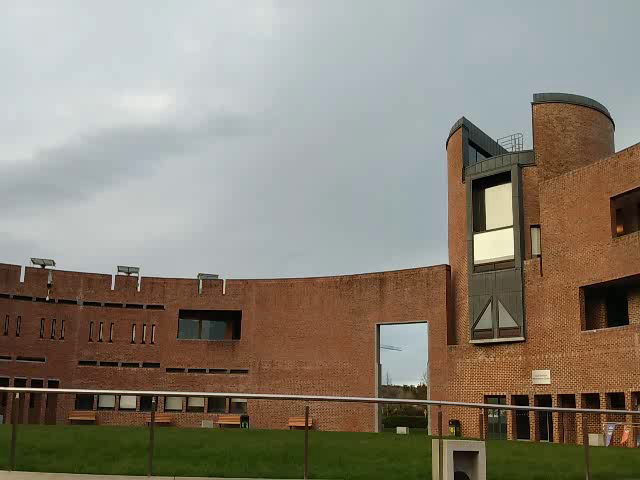

In [ ]:
frame_0 = cv2.imread('/content/frame_0.png')
cv2_imshow(frame_0)

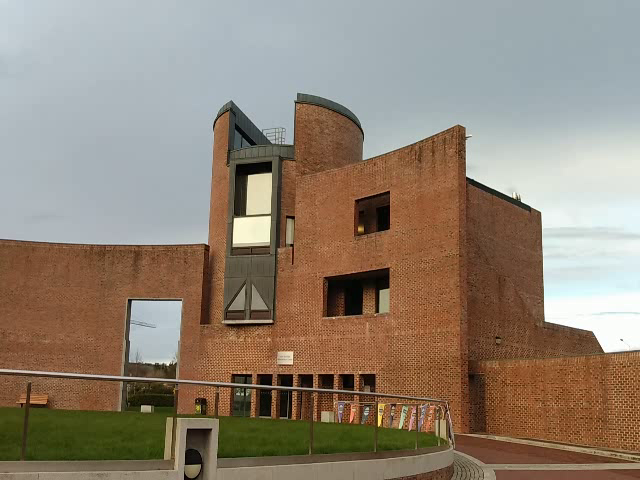

In [ ]:
frame_1 = cv2.imread('/content/frame_1.png')
cv2_imshow(frame_1)

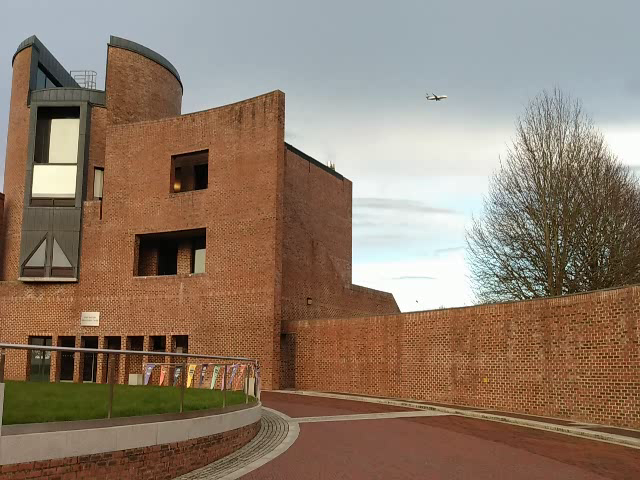

In [ ]:
frame_2 = cv2.imread('/content/frame_2.png')
cv2_imshow(frame_2)

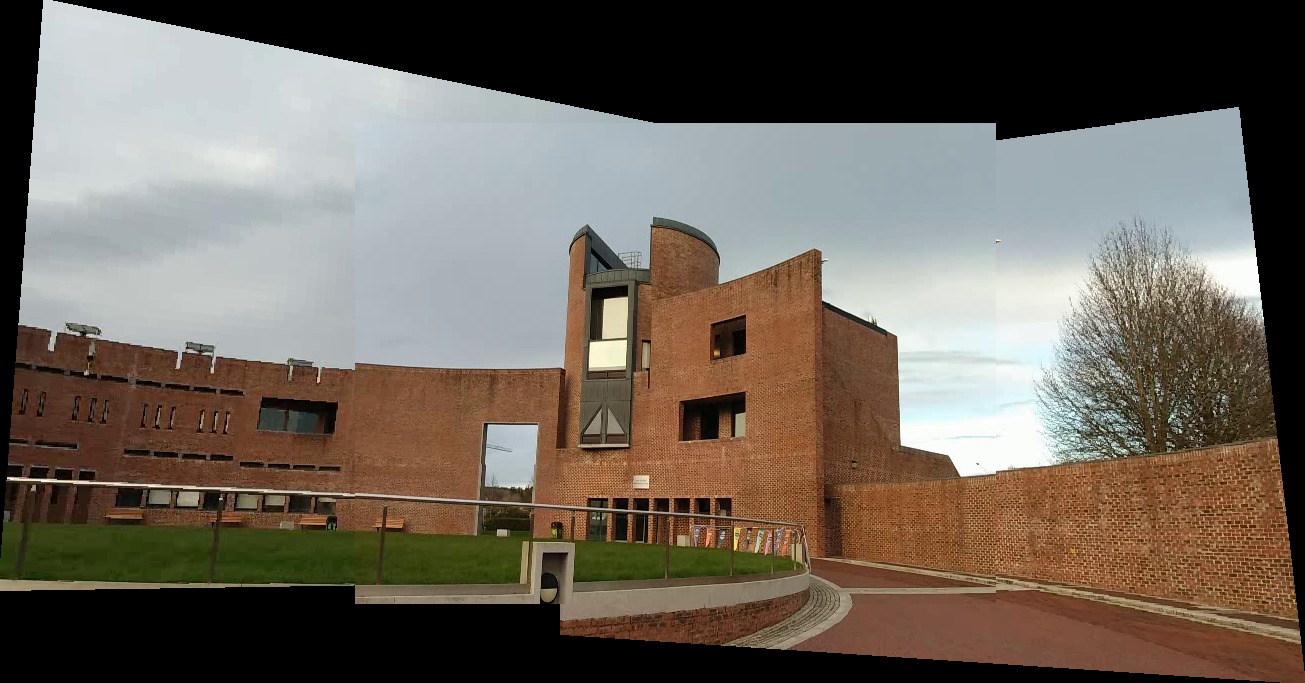

In [ ]:
frame_0 = cv2.imread('/content/stitching_result_RANSAC.png')
cv2_imshow(frame_0)